###  Example of the coherence computation

In this notebook we use the autoregressive example model from [Dhamala et. al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.018701). The model consists of two coupled random variables ($2\rightarrow 1$), the coupling is time-varying therefore the coherence should detect the coupling dynamics. The model is given by the equations bellow:

$X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

$X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

Here, $X_1(t)$ and $X_2(t)$ are $AR(2)$. The variable $t$ is the time step index,
such that the actual time is $t'=t\,\Delta t=t/f_{\rm s}$. Besides, we know by construction that
$X_2(t)$ influences $X_1(t)$ through the coupling constant $C$
(although the opposite does not happen). In the simulations bellow we will consider four different stimulus that can be presented to the system and the coupling resulting from this will be dependend on the stimulus in the following manner:

- Stim 1: C(t) = 0;
- Stim 2: C(t) = 0.20;
- Stim 2: C(t) = 0.40;
- Stim 3: C(t) = 0.60;

To begin with the coupling is always turned off at $15$ s.

In [2]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

import itertools
import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
import matplotlib
import GDa.graphics.plot     as     plot
from   tqdm                   import tqdm
from   xfrites.conn.conn_spec import conn_spec

In [3]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()
bands = ['0-25Hz','25-50Hz', '50-75Hz','75-100Hz']

In [4]:
# Create directory to save figures
if not os.path.exists("img/n3.0.1"):
    os.makedirs("img/n3.0.1")

#### Defining function to simulate de model

In [13]:
def ar_model_dhamala(N=5000, Fs = 200, C=0.2, t_start=0, stim = None, t_stop=None, cov = None):
    ''' 
        AR model from Dhamala et. al.
    '''
    
    T = N / Fs
    
    Trials = len(stim)

    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N]) 
    Y = np.random.random([Trials, N]) 

    def interval(t, t_start, t_stop):
        if t_stop==None:
            return (t>=t_start)
        else:
            return (t>=t_start)*(t<=t_stop)

    for i in tqdm( range(Trials) ):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N): 
            X[i,t] = 0.55*X[i,t-1] - 0.8*X[i,t-2] + interval(time[t],t_start,t_stop)*C[i]*Y[i,t-1] + E[t,0]
            Y[i,t] = 0.55*Y[i,t-1] - 0.8*Y[i,t-2] + E[t,1]

    Z = np.zeros([Trials,2,N]) 

    Z[:,0,:] = X 
    Z[:,1,:] = Y 

    return Z

Model parameters

In [14]:
N  = 5000      # Number of observations
Fs = 200       # Sampling frequency
dt = 1.0 / Fs  # Time resolution
C  = 0.25      # Coupling parameter
Trials = 1000   # Number of trials
freqs  = np.arange(1,100,1) # Frequency axis
# Covariance matrix
cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])

# Stim array 
stim = np.random.randint(0,4,Trials)
# Coupling for each stimulus
C    = stim/10*2

Generating data

In [15]:
# Generating data
X = ar_model_dhamala(N=N, C=C, Fs=Fs, stim=stim, t_start=0, t_stop=15, cov=cov)

100%|██████████| 1000/1000 [00:32<00:00, 31.19it/s]


In [16]:
X = xr.DataArray(X, dims=('trials', 'roi', 'times'),
                 coords=(np.arange(Trials), ['r0', 'r1'], np.arange(N) / Fs))

### Measuring coherence

To compute the coherence first the cross ($S_{12}(f,t)$), and auto-spectogram ($S_{11}(f,t)$ and $S_{22}(f,t)$) are computed. The coherence is defined as:

$C_{12}(f,t) = \frac{S_{12}S_{12}^{*}}{S_{11}S_{22}}$

However, for the equation above $C_{12}(f,t)=1$ $\forall \text{  } f, \text{ and } t$. Therefore, before taking the ratio in the equation above some temporal and frequency smoothing should be done. To do this, we convolve the auto- and cross-spectogram with a square window of size $w_f$, and $w_rt$, for the frequency and time axis, respectively.

Let's $g(w_t,w_f)$ be the filter, and $\tilde{g}(w_t,w_f)$ its representation in the frequency domain. We can then convolve each spectra with $g$, which gives:

$C_{12}(f,t) = \frac{\tilde{g}*(S_{12}S_{12}^{*})}{\tilde{g}*(S_{11})\tilde{g}*(S_{22})}$

Note that we ommit the dependencies on $f$ and $t$ for the spectra, and on $w_t$ and $w_f$ for the filter.

In [17]:
start = time.time()

# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times="times", roi=None, foi=None, n_jobs=-1,
    mode='morlet', n_cycles=n_cycles, decim=15, metric="coh",
    sm_times=1.5, sm_freqs=1, block_size=1
)

# compute the coherence
coh = conn_spec(X, **kw)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   14.0s finished


  0%|          | Estimating pairwise Coherence : 0/1 [00:00<?,       ?it/s]

Elapsed time to load super-tensor: 23.104053735733032 sec.


Text(0.5, 1.0, 'Coherence')

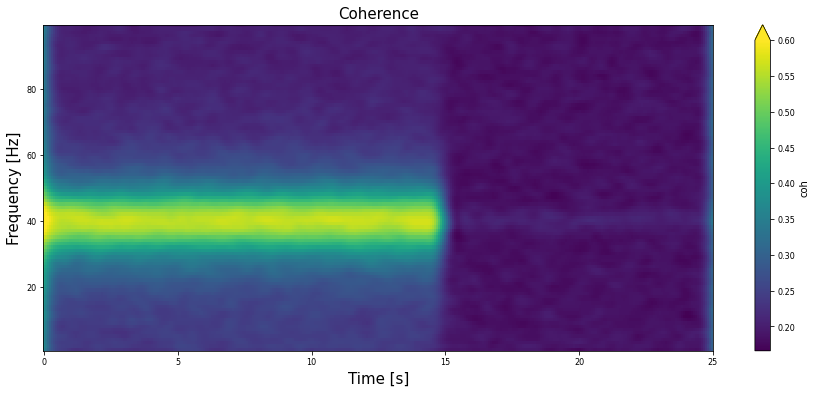

In [18]:
plt.figure(figsize=(15,6))
coh.isel(roi=0).mean(dim="trials").plot.imshow(x="times", y="freqs", vmax=.6)
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [s]', fontsize=15)
plt.title('Coherence', fontsize=15)

### MI workflow

In [19]:
from frites.dataset  import SubjectEphy, DatasetEphy
from frites.workflow import WfMi

In [20]:
dt = DatasetEphy([coh], y=[stim], times="times", roi="roi", agg_ch=True)

Definition of an electrophysiological dataset
    Dataset composed of 1 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)


In [21]:
mi_type   = 'cd'
inference = 'ffx'
kernel    = np.hanning(1)
wf        = WfMi(mi_type, inference, verbose=True, kernel=kernel)

Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cd)


In [ ]:
# list of corrections for multiple comparison
mcps = ['cluster', 'maxstat', 'fdr', 'bonferroni']
kw = dict(n_jobs=20, n_perm=100)
"""
The `cluster_th` input parameter specifies how the threshold is defined.
Use either :
* a float for a manual threshold
* None and it will be infered using the distribution of permutations
* 'tfce' for a TFCE threshold
"""
cluster_th = 'tfce'  # {float, None, 'tfce'}

mi, pvalues = wf.fit(dt, mcp="cluster", cluster_th=cluster_th, **kw)

    Evaluate true and permuted mi (n_perm=100, n_jobs=20)


  0%|          | Estimating MI : 0/1 [00:00<?,       ?it/s]

    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=True)
    Inference at cluster-level
    Cluster detection (threshold={'start': 0.004547944758087397, 'step': 0.007711978047154844, 'e_power': 0.5, 'h_power': 2}; tail=1)


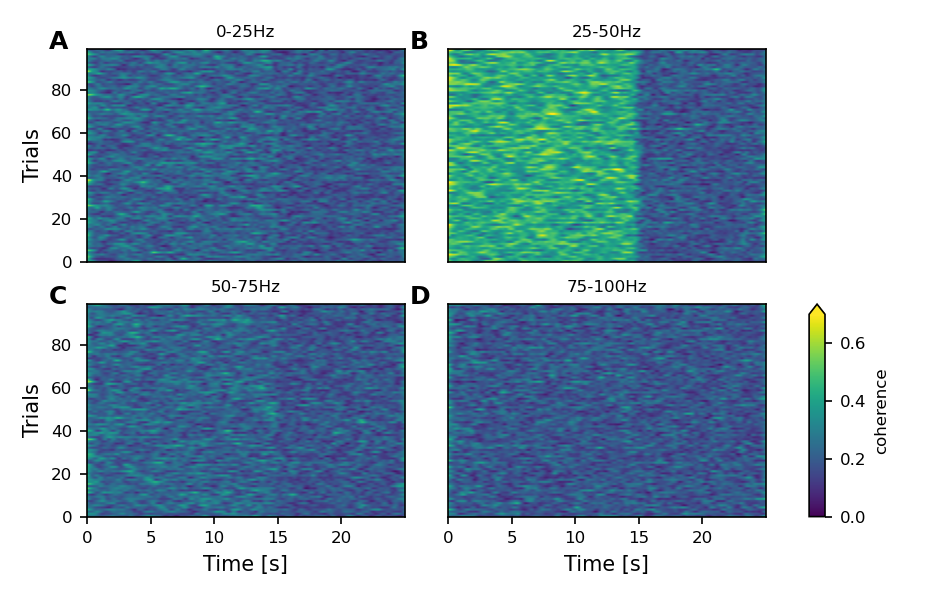

In [14]:
plt.figure(figsize=(12,4))
aux = mi*(pvalues<=0.05)
plt.plot(aux.times, aux.mean("roi").T)
plt.title("MI(power,stim)", fontsize=MEDIUM_SIZE)
plt.legend(band_names)
plt.ylabel("Freqs [Hz]", fontsize=MEDIUM_SIZE)
plt.xlabel("Time [s]", fontsize=MEDIUM_SIZE)
plt.xlim(aux.times[0], aux.times[-1])